## MNIST手写体识别

In [16]:
from __future__ import division
from __future__ import absolute_import
from __future__ import print_function

import tensorflow as tf
import numpy as np

# Tensorflow 已经把 mnist 数据集集成在 examples 里面了
# 在这里 import 数据输入的部分
import tensorflow.examples.tutorials.mnist.input_data as input_data
tf.logging.set_verbosity(tf.logging.ERROR)
tf.set_random_seed(2017)

导入`mnist`数据集 ,注意：需要下载mnist数据集，存放在当前程序的MNIST_data文件夹

In [17]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


**`one_hot`**将一个数`n`映射到一个向量, 这个向量的第`n`个元素是`1`, 其他元素都是`0`.

In [18]:
train_set = mnist.train
test_set = mnist.test

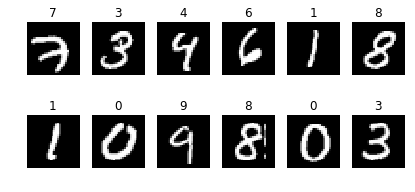

In [19]:
import matplotlib.pyplot as plt

%matplotlib inline

fig, axes = plt.subplots(ncols=6, nrows=2)
plt.tight_layout(w_pad=-2.0, h_pad=-8.0)

# 调用next_batch方法来一次性获取12个样本,
# 这里有一个`shuffle`参数, 表达是否打乱样本间的顺序
images, labels = train_set.next_batch(12, shuffle=False)

for ind, (image, label) in enumerate(zip(images, labels)):
    # image 是一个 784 维的向量, 是图片进行拉伸产生的, 这里我们给它 reshape 回去
    image = image.reshape((28, 28))
    
    # label 是一个 10 维的向量, 哪个下标处的值为1 说明是数字几
    label = label.argmax()

    row = ind // 6
    col = ind % 6
    axes[row][col].imshow(image, cmap='gray') # 灰度图
    axes[row][col].axis('off')
    axes[row][col].set_title('%d' % label)

定义深度网络结构

In [20]:
def hidden_layer(layer_input, output_depth, scope='hidden_layer', reuse=None):
    input_depth = layer_input.get_shape()[-1]
    with tf.variable_scope(scope, reuse=reuse):
        # 注意这里的初始化方法是truncated_normal
        w = tf.get_variable(initializer=tf.truncated_normal_initializer(stddev=0.1), shape=(input_depth, output_depth), name='weights')
        # 注意这里用 0.1 对偏置进行初始化
        b = tf.get_variable(initializer=tf.constant_initializer(0.1), shape=(output_depth), name='bias')
        net = tf.matmul(layer_input, w) + b
        
        return net

def DNN(x, output_depths, scope='DNN', reuse=None):
    net = x
    for i, output_depth in enumerate(output_depths):
        net = hidden_layer(net, output_depth, scope='layer%d' % i, reuse=reuse)
        # 注意这里的激活函数
        net = tf.nn.relu(net)
    # 数字分为0, 1, ..., 9 所以这是10分类问题
    # 对应于 one_hot 的标签, 所以这里输出一个 10维 的向量
    net = hidden_layer(net, 10, scope='classification', reuse=reuse)
    
    return net

In [21]:
# 定义占位符
input_ph = tf.placeholder(shape=(None, 784), dtype=tf.float32)
label_ph = tf.placeholder(shape=(None, 10), dtype=tf.int64)

构造一个4层的神经网络, 它的隐藏节点数分别为: 400, 200, 100, 10

In [22]:
dnn = DNN(input_ph, [400, 200, 100])

In [23]:
# 这是一个分类问题, 因此我们采用交叉熵来计算损失函数
loss = tf.losses.softmax_cross_entropy(logits=dnn, onehot_labels=label_ph)

# 下面定义的是正确率
acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(dnn, axis=-1), tf.argmax(label_ph, axis=-1)), dtype=tf.float32))

lr = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

In [24]:
sess = tf.InteractiveSession()

In [25]:
# 我们训练20000次

batch_size = 64

sess.run(tf.global_variables_initializer())

for e in range(20000):
    # 获取 batch_size个训练样本
    images, labels = train_set.next_batch(batch_size)
    sess.run(train_op, feed_dict={input_ph: images, label_ph: labels})
    if e % 1000 == 999:
        # 获取 batch_size 个测试样本
        test_imgs, test_labels = test_set.next_batch(batch_size)
        # 计算在当前样本上的训练以及测试样本的损失值和正确率
        loss_train, acc_train = sess.run([loss, acc], feed_dict={input_ph: images, label_ph: labels})
        loss_test, acc_test = sess.run([loss, acc], feed_dict={input_ph: test_imgs, label_ph: test_labels})
        print('STEP {}: train_loss: {:.6f} train_acc: {:.6f} test_loss: {:.6f} test_acc: {:.6f}'.format(e + 1, loss_train, acc_train, loss_test, acc_test))

print('Train Done!')
print('-'*30)

# 计算所有训练样本的损失值以及正确率
train_loss = []
train_acc = []
for _ in range(train_set.num_examples // 100):
    image, label = train_set.next_batch(100)
    loss_train, acc_train = sess.run([loss, acc], feed_dict={input_ph: image, label_ph: label})
    train_loss.append(loss_train)
    train_acc.append(acc_train)

print('Train loss: {:.6f}'.format(np.array(train_loss).mean()))
print('Train accuracy: {:.6f}'.format(np.array(train_acc).mean()))

# 计算所有测试样本的损失值以及正确率
test_loss = []
test_acc = []
for _ in range(test_set.num_examples // 100):
    image, label = test_set.next_batch(100)
    loss_test, acc_test = sess.run([loss, acc], feed_dict={input_ph: image, label_ph: label})
    test_loss.append(loss_test)
    test_acc.append(acc_test)

print('Test loss: {:.6f}'.format(np.array(test_loss).mean()))
print('Test accuracy: {:.6f}'.format(np.array(test_acc).mean()))

STEP 1000: train_loss: 0.508492 train_acc: 0.859375 test_loss: 0.381910 test_acc: 0.890625
STEP 2000: train_loss: 0.273127 train_acc: 0.906250 test_loss: 0.308092 test_acc: 0.937500
STEP 3000: train_loss: 0.300943 train_acc: 0.921875 test_loss: 0.129283 test_acc: 0.968750
STEP 4000: train_loss: 0.287253 train_acc: 0.906250 test_loss: 0.137666 test_acc: 0.953125
STEP 5000: train_loss: 0.158111 train_acc: 0.968750 test_loss: 0.343043 test_acc: 0.921875
STEP 6000: train_loss: 0.049266 train_acc: 0.984375 test_loss: 0.234881 test_acc: 0.937500
STEP 7000: train_loss: 0.148513 train_acc: 0.953125 test_loss: 0.145246 test_acc: 0.937500
STEP 8000: train_loss: 0.168960 train_acc: 0.953125 test_loss: 0.194879 test_acc: 0.921875
STEP 9000: train_loss: 0.077116 train_acc: 0.968750 test_loss: 0.124628 test_acc: 0.968750
STEP 10000: train_loss: 0.121345 train_acc: 0.984375 test_loss: 0.105184 test_acc: 0.937500
STEP 11000: train_loss: 0.078549 train_acc: 0.984375 test_loss: 0.070529 test_acc: 0.9687

在训练集上大约0.98的正确率, 在测试集上大约0.97的正确率

In [26]:
sess.close()

## Tensorboard & `tf.summary`

`Tensorboard`和`tf.summary`结合起来可以实现可视化训练. 

首先介绍一下`tf.summary`, 它能够收集训练过程中的各种`tensor`的信息并把它保存起来以供`Tensorboard`读取并展示. 按照下面的方法来使用它:

### 构造`summary`
- - -
- 如果你想收集一个标量或者一个数的`tensor`的信息, 比如上面的`loss`
```python
loss_sum = tf.summary.scalar('loss', loss)
```

- - -
- 如果你想收集一个`tensor`的分布情况, 这个`tensor`可以是任意形状, 比如我们定义了一个`(784, 400)`的权重`w`
```python
w_hist = tf.summary.histogram('w_hist', w)
```
- - -
- 如果你想收集一个4维的1-通道(灰度图), 3-通道(RGB), 4-通道(RGBA)的`tensor`的变化, 比如我们输出了一个`(1, 8, 8, 1)`的灰度图`image`
```python
image_sum = tf.summary.image('image', image)
```
- - -
- 如果你想收集一个3维(batch, frame, channel), 2维(batch, frame)的变化, 比如我们输出了一个`(10, 50, 3)`的`tensor`:`audio`
```python
audio_sum = tf.summary.audio('audio', audio)
```
- - -

In [27]:
# 重置计算图
tf.reset_default_graph()

# 重新定义占位符
input_ph = tf.placeholder(shape=(None, 784), dtype=tf.float32)
label_ph = tf.placeholder(shape=(None, 10), dtype=tf.int64)

In [28]:
# 构造权重, 用`truncated_normal`初始化
def weight_variable(shape):
    init = tf.truncated_normal(shape=shape, stddev=0.1)
    return tf.Variable(init)

# 构造偏置, 用`0.1`初始化
def bias_variable(shape):
    init = tf.constant(0.1, shape=shape)
    return tf.Variable(init)

In [29]:
# 构造添加`variable`的`summary`的函数
def variable_summaries(var):
    with tf.name_scope('summaries'):
        # 计算平均值
        mean = tf.reduce_mean(var)
        # 将平均值添加到`summary`中, 这是一个数值, 所以我们用`tf.summary.scalar`
        tf.summary.scalar('mean', mean)
        
        # 计算标准差
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        # 将标准差添加到`summary`中
        tf.summary.scalar('stddev', stddev)
        
        # 添加最大值,最小值`summary`
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        
        # 添加这个变量分布情况的`summary`, 我们希望观察它的分布, 所以用`tf.summary.histogram`
        tf.summary.histogram('histogram', var)

In [30]:
# 构造一个隐藏层
def hidden_layer(x, output_dim, scope='hidden_layer', act = tf.nn.relu, reuse=None):
    # 获取输入的`depth`
    input_dim = x.get_shape().as_list()[-1]
    
    with tf.name_scope(scope):
        with tf.name_scope('weight'):
            # 构造`weight`
            weight = weight_variable([input_dim, output_dim])
            # 添加`weight`的`summary`
            variable_summaries(weight)
            
        with tf.name_scope('bias'):
            # 构造`bias`
            bias = bias_variable([output_dim])
            # 添加`bias`的`summary`
            variable_summaries(bias)
            
        with tf.name_scope('linear'):
            # 计算`xw+b`
            preact = tf.matmul(x, weight) + bias
            # 添加激活层之前输出的分布情况到`summary`
            tf.summary.histogram('pre_activation', preact)
            
        # 经过激活层`act`
        output = act(preact)
        # 添加激活后输出的分布情况到`summary`
        tf.summary.histogram('output', output)
        return output

In [31]:
# 构造深度神经网络
def DNN(x, output_depths, scope='DNN_with_sums', reuse=None):
    with tf.name_scope(scope):
        net = x
        for i, output_depth in enumerate(output_depths):
            net = hidden_layer(net, output_depth, scope='hidden%d' % (i + 1), reuse=reuse)
        # 最后有一个分类层
        net = hidden_layer(net, 10, scope='classification', act=tf.identity, reuse=reuse)
        return net

dnn_with_sums = DNN(input_ph, [400, 200, 100])

In [32]:
# 重新定义`loss`, `acc`, `train_op`
with tf.name_scope('cross_entropy'):
    loss = tf.losses.softmax_cross_entropy(logits=dnn_with_sums, onehot_labels=label_ph)
    tf.summary.scalar('cross_entropy', loss)
    
with tf.name_scope('accuracy'):
    acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(dnn_with_sums, axis=-1), tf.argmax(label_ph, axis=-1)), dtype=tf.float32))
    tf.summary.scalar('accuracy', acc)

with tf.name_scope('train'):
    lr = 0.01
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
    train_op = optimizer.minimize(loss)

### 融合`summary`
- - -
- 我们可以把前面定义的所有`summary`都融合成一个`summary`
```python
merged = tf.summary.merge_all()
```
- - -
- 也可以只是融合某些`summary`
```python
merged = tf.summary.merge([loss_sum, image_sum])
```

In [33]:
merged = tf.summary.merge_all()

In [34]:
sess = tf.InteractiveSession()

### 输出`summary`
---
`summary`是需要导出到外部文件的
- 首先定义一个文件读写器
```python
summary_writer = tf.summary.FileWriter('summaries', sess.graph)
```
- - -
- 然后在训练的过程中, 在你希望的时候运行一次`merged`或者是你之前自己定义的某个通过`summary`定义的`op`
```python
summaries = sess.run(merged, feed_dict={...})
```
- - -
- 然后将这个`summaries`写入到`summari_writer`内
```python
summary_writer.add_summary(summaries, step)
```
注意`step`表示你当前训练的步数, 当然你也可以设定为其他你想要用的数值

- - -
- 最后关闭文件读写器
```python
summary_writer.close()
```

In [35]:
train_writer = tf.summary.FileWriter('test_summary/train', sess.graph)
test_writer = tf.summary.FileWriter('test_summary/test', sess.graph)

In [36]:
batch_size = 64

sess.run(tf.global_variables_initializer())

for e in range(20000):
    images, labels = train_set.next_batch(batch_size)
    sess.run(train_op, feed_dict={input_ph: images, label_ph: labels})
    if e % 1000 == 999:
        test_imgs, test_labels = test_set.next_batch(batch_size)
        # 获取`train`数据的`summaries`以及`loss`, `acc`信息
        sum_train, loss_train, acc_train = sess.run([merged, loss, acc], feed_dict={input_ph: images, label_ph: labels})
        # 将`train`的`summaries`写入到`train_writer`中
        train_writer.add_summary(sum_train, e)
        # 获取`test`数据的`summaries`以及`loss`, `acc`信息
        sum_test, loss_test, acc_test = sess.run([merged, loss, acc], feed_dict={input_ph: test_imgs, label_ph: test_labels})
        # 将`test`的`summaries`写入到`test_writer`中
        test_writer.add_summary(sum_test, e)
        print('STEP {}: train_loss: {:.6f} train_acc: {:.6f} test_loss: {:.6f} test_acc: {:.6f}'.format(e + 1, loss_train, acc_train, loss_test, acc_test))

# 关闭读写器
train_writer.close()
test_writer.close()

print('Train Done!')
print('-'*30)

# 计算所有训练样本的损失值以及正确率
train_loss = []
train_acc = []
for _ in range(train_set.num_examples // 100):
    image, label = train_set.next_batch(100)
    loss_train, acc_train = sess.run([loss, acc], feed_dict={input_ph: image, label_ph: label})
    train_loss.append(loss_train)
    train_acc.append(acc_train)

print('Train loss: {:.6f}'.format(np.array(train_loss).mean()))
print('Train accuracy: {:.6f}'.format(np.array(train_acc).mean()))

# 计算所有测试样本的损失值以及正确率
test_loss = []
test_acc = []
for _ in range(test_set.num_examples // 100):
    image, label = test_set.next_batch(100)
    loss_test, acc_test = sess.run([loss, acc], feed_dict={input_ph: image, label_ph: label})
    test_loss.append(loss_test)
    test_acc.append(acc_test)

print('Test loss: {:.6f}'.format(np.array(test_loss).mean()))
print('Test accuracy: {:.6f}'.format(np.array(test_acc).mean()))

STEP 1000: train_loss: 0.425742 train_acc: 0.906250 test_loss: 0.335134 test_acc: 0.906250
STEP 2000: train_loss: 0.437294 train_acc: 0.859375 test_loss: 0.348037 test_acc: 0.843750
STEP 3000: train_loss: 0.161168 train_acc: 0.937500 test_loss: 0.271150 test_acc: 0.921875
STEP 4000: train_loss: 0.070931 train_acc: 0.984375 test_loss: 0.083520 test_acc: 0.984375
STEP 5000: train_loss: 0.078938 train_acc: 1.000000 test_loss: 0.082872 test_acc: 0.968750
STEP 6000: train_loss: 0.183314 train_acc: 0.953125 test_loss: 0.063439 test_acc: 0.984375
STEP 7000: train_loss: 0.038420 train_acc: 1.000000 test_loss: 0.097311 test_acc: 0.953125
STEP 8000: train_loss: 0.086733 train_acc: 0.953125 test_loss: 0.127061 test_acc: 0.953125
STEP 9000: train_loss: 0.225148 train_acc: 0.921875 test_loss: 0.192060 test_acc: 0.953125
STEP 10000: train_loss: 0.019210 train_acc: 1.000000 test_loss: 0.090455 test_acc: 0.968750
STEP 11000: train_loss: 0.041655 train_acc: 1.000000 test_loss: 0.085112 test_acc: 0.9843

### 打开`Tensorboard`

在`test_summary`目录中输入以下命令
```
$ tensorboard --logdir=train:train/,test:test/
```